In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import warnings
warnings.filterwarnings("ignore")

In [7]:
import gzip

# Path to the compressed TSV file
file_path = "data/7_ovary.tsv.gz"

# Open the gzip file and read it using pandas
with gzip.open(file_path, 'rt') as f:
    # Read the TSV file using pandas
    data = pd.read_csv(f, sep='\t',header=None)

In [8]:
data.set_index(data.columns[0], inplace=True)

In [9]:
data

,1,2,3,4,5,6,7,8,9,10,...,7540,7541,7542,7543,7544,7545,7546,7547,7548,7549
0,,,,,,,,,,,,,,,,,,,,,
128up,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14-3-3epsilon,1,0,2,2,1,1,2,0,3,0,...,0,4,1,0,0,0,1,3,4,0
14-3-3zeta,1,2,1,2,1,0,3,0,3,8,...,2,5,3,3,1,1,0,2,8,6
140up,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18SrRNA-Psi:CR41602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zormin,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zpg,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
zuc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
adata = sc.AnnData(data.T)
adata

AnnData object with n_obs × n_vars = 7549 × 11944

the dataset has the shape barcodes (cells) x number of transcripts

###Quality Control Analysis QC

In [21]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("mt:")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt','ribo'], percent_top=[20], log1p=True, inplace=True
)

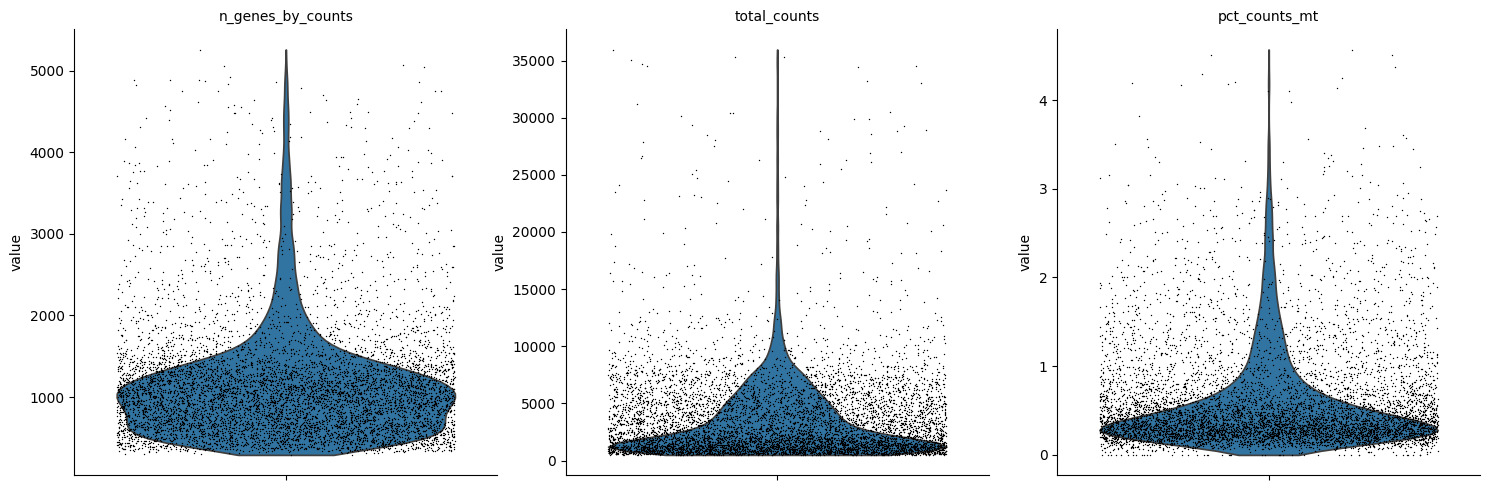

In [22]:
# violin plot
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
# n_genes_by_counts: number genes with positive counts per cell
# total_counts: total nbr of counts per cell (total library)
# pct_counts_mnt: proportion of total counts for mitochondrial cells

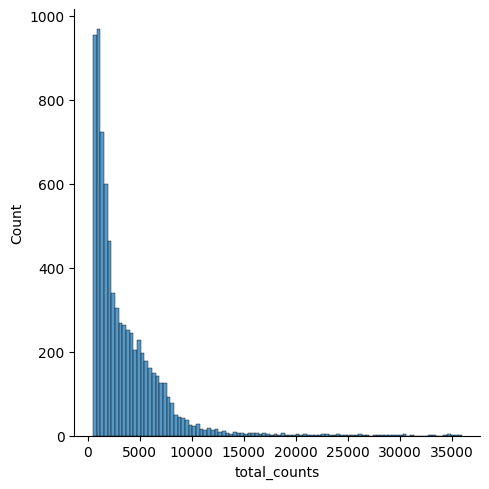

In [23]:
sns.displot(adata.obs["total_counts"], bins=100, kde=False)

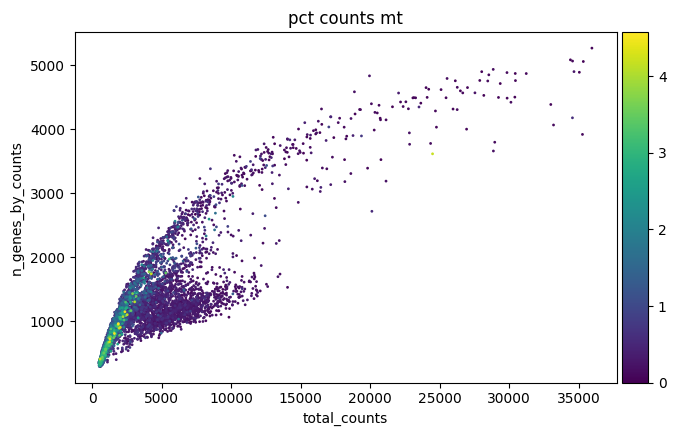

In [25]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Low complexity of genes and high mitochondrial read content have been used as a proxy for identifying poor-quality cells . High gene complexity has been used as a proxy for doublets or multiplets in droplet-based sequencing.

### Identifiying Outliers

Because we don't want to filter out too much, we first perform a basic qc with high quality cells defined as >= 100 genes, >= 3 cells <= 80% mito. We will calculate median absolute deviation (MAD) based thresholds after dimensionality reduction and clustering for each cluster

In [26]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs["pct_counts_mt"] <= 1, :]

In [27]:
adata

View of AnnData object with n_obs × n_vars = 6345 × 11218
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'pct_counts_in_top_20_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells'

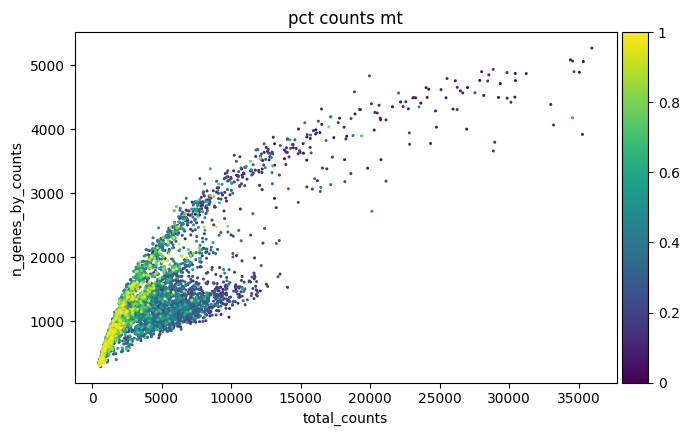

In [28]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Normalization 
Normalize the feature expression measurements for each cell by the total expression, multiply by a scale factor (10,000) and log-transfrom the result to get log(TPX + 1) values

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)

2. Log normalize: log2(1+x) => easier to compare genes with different levels of expression 

In [30]:
# Log normalize gene expression using log2(1+x) transformation
sc.pp.log1p(adata)

3. Highly Variable genes are used to compute the PCA . As PCA doesn't work well with too many features, you limit your data to highly variable genes to compute PCA. Keep and mark the genes with the higher variance (2000 genese with most variance): compute the average + variance, keep the ones with highest variance, first 2000

In [31]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# Get the names of the most variable genes
highly_variable_genes = adata[:, adata.var.highly_variable]

# Print the names of the 2000 most variable genes
print("Names of the 2000 most variable genes:")
highly_variable_genes.var

Names of the 2000 most variable genes:


,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,log1p_mean_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
0,,,,,,,,,,,,,
28SrRNA-Psi:CR40596,False,False,524,0.080408,93.058683,607,0.077339,6.410175,524,True,0.236907,1.940362,0.900982
28SrRNA-Psi:CR45848,False,False,20,0.002914,99.735064,22,0.002910,3.135494,20,True,0.008041,1.934334,0.888260
2mit,False,False,70,0.009538,99.072725,72,0.009492,4.290459,70,True,0.051481,2.003145,1.033499
5-HT1A,False,False,4,0.000662,99.947013,5,0.000662,1.791759,4,True,0.003793,2.049678,1.131715
5-HT1B,False,False,7,0.000927,99.907272,7,0.000927,2.079442,7,True,0.006222,2.141395,1.325302
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zfh1,False,False,818,0.348920,89.164128,2634,0.299305,7.876638,818,True,0.565772,3.698479,3.601182
zfh2,False,False,250,0.044774,96.688303,338,0.043801,5.826000,250,True,0.105849,2.263347,1.582707
zld,False,False,1167,0.359650,84.540999,2715,0.307228,7.906915,1167,True,0.542904,2.304330,1.249246


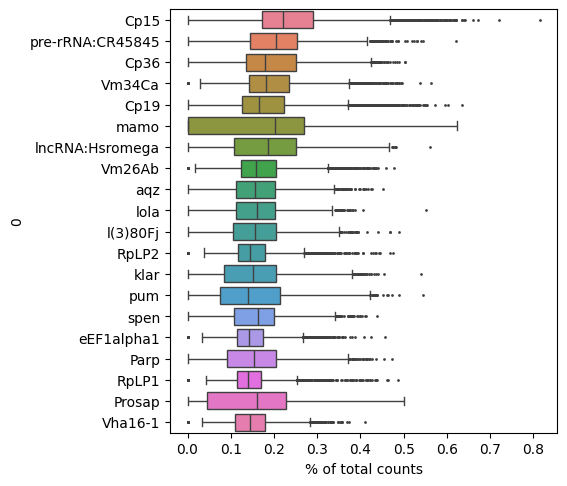

In [32]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [33]:
adata

AnnData object with n_obs × n_vars = 6345 × 11218
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'pct_counts_in_top_20_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Dimensionality reduction

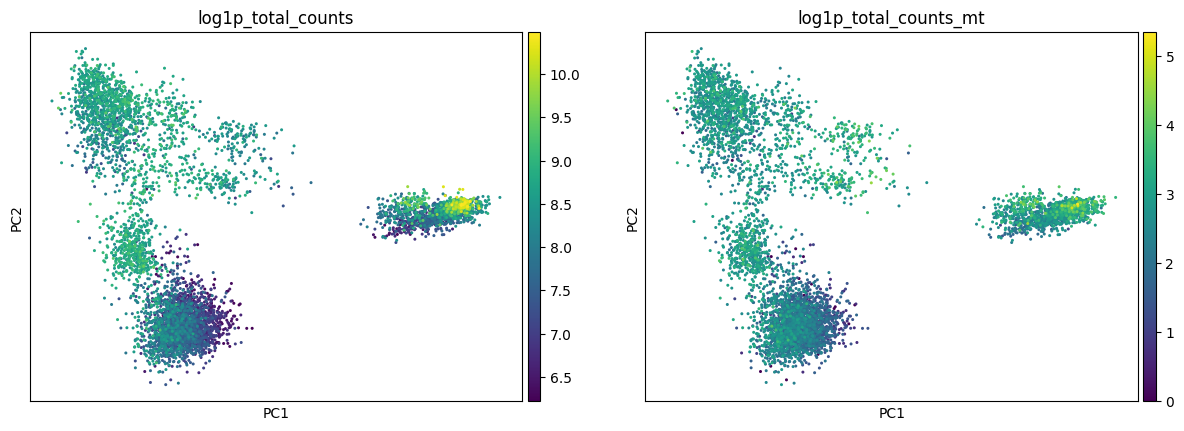

In [36]:
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca(adata,color=['log1p_total_counts','log1p_total_counts_mt'])

In [37]:
adata

AnnData object with n_obs × n_vars = 6345 × 11218
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'pct_counts_in_top_20_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

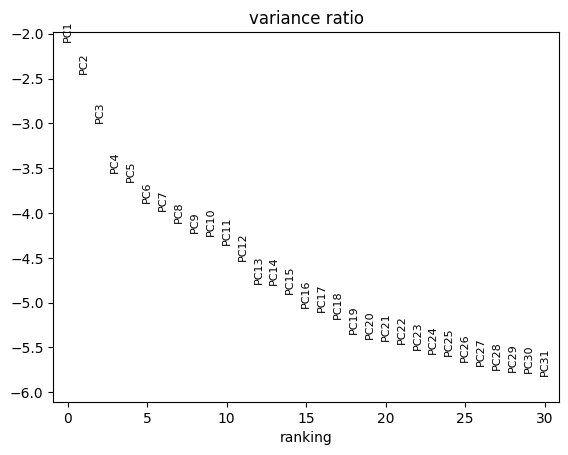

In [38]:
sc.pl.pca_variance_ratio(adata, log=True)

### Neighbourhood

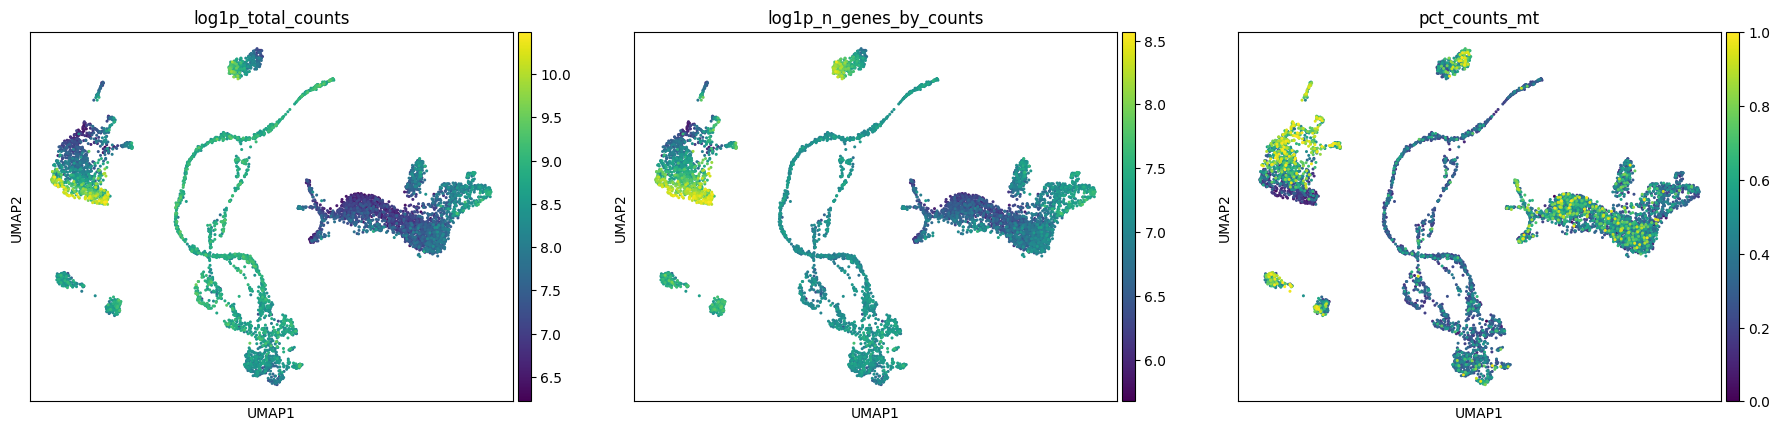

In [40]:
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts','log1p_n_genes_by_counts','pct_counts_mt'])

### Clustering

In [43]:
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)


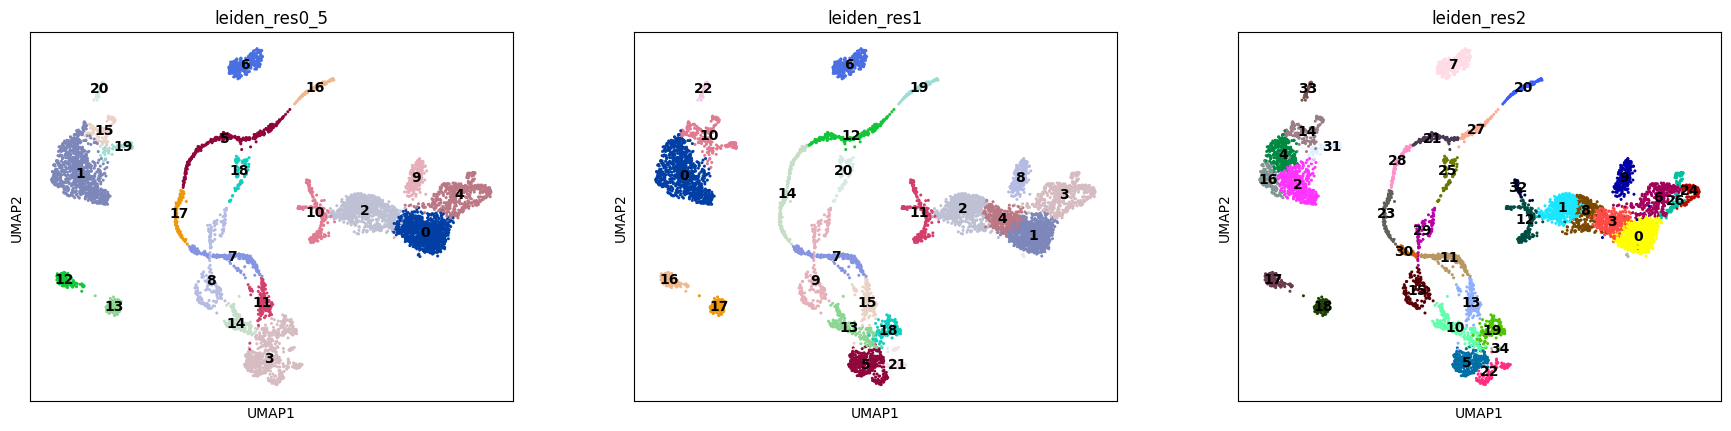

In [44]:
sc.pl.umap(adata, color=["leiden_res0_5", "leiden_res1","leiden_res2"],legend_loc="on data",);

### finding marker genes

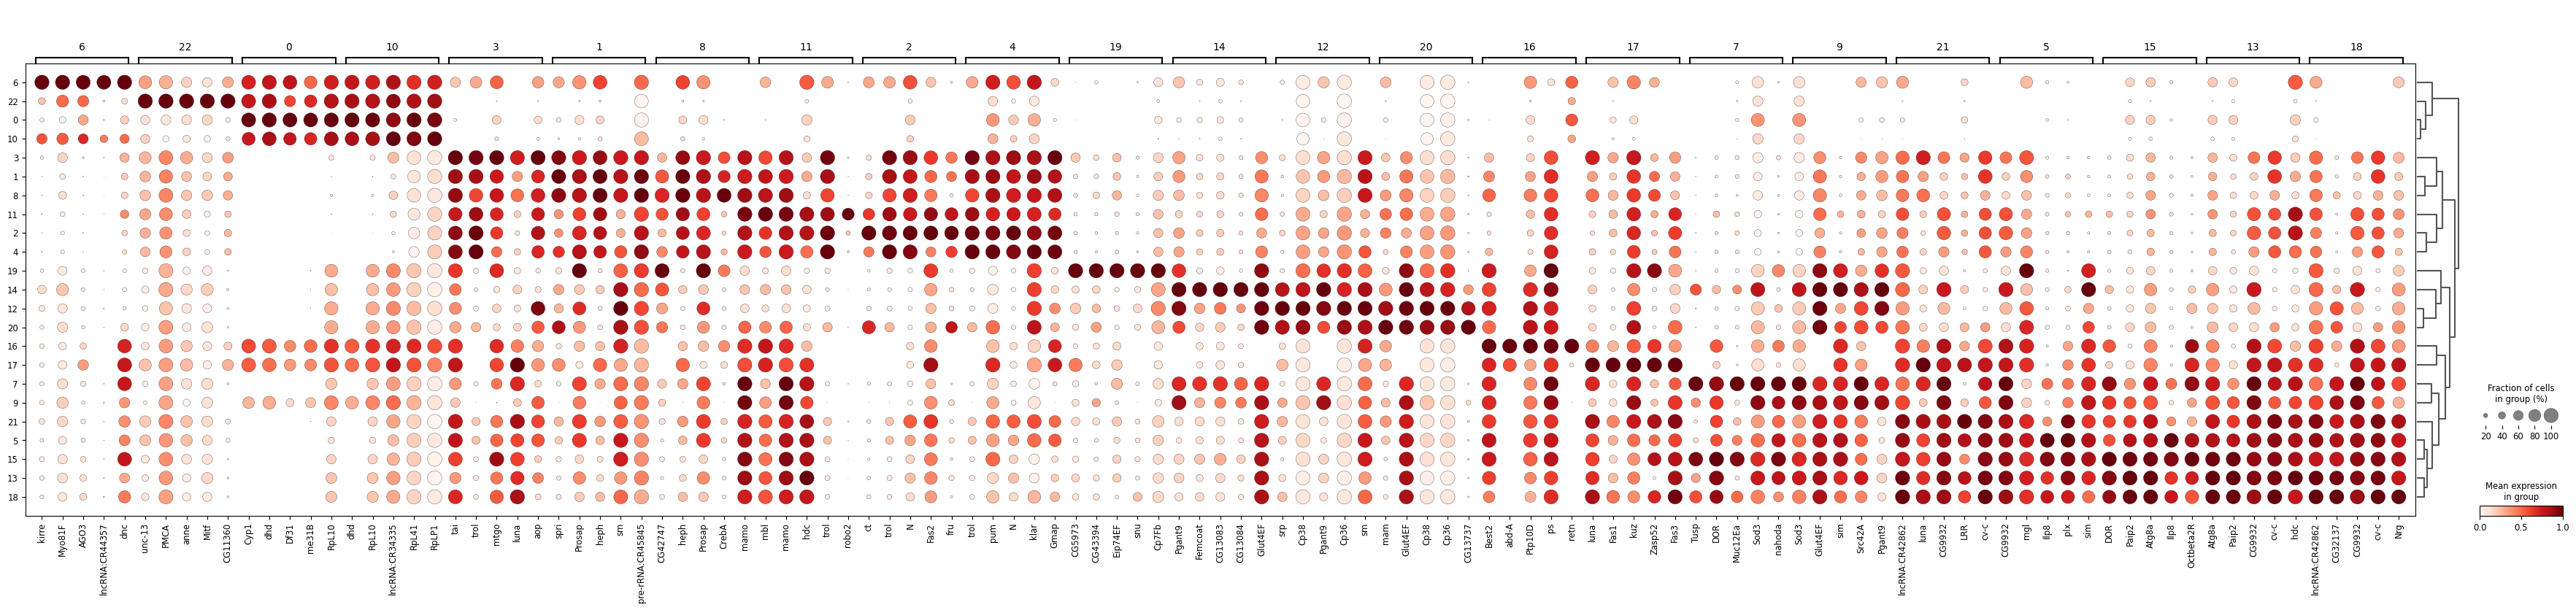

In [45]:
sc.tl.rank_genes_groups(adata, groupby="leiden_res1", method="t-test", key_added="dea_leiden_1") # differentially expressed genes per cluster.
# compare to rest of cells in dataset

#Visualize:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res1", standard_scale="var", n_genes=5, key="dea_leiden_1")


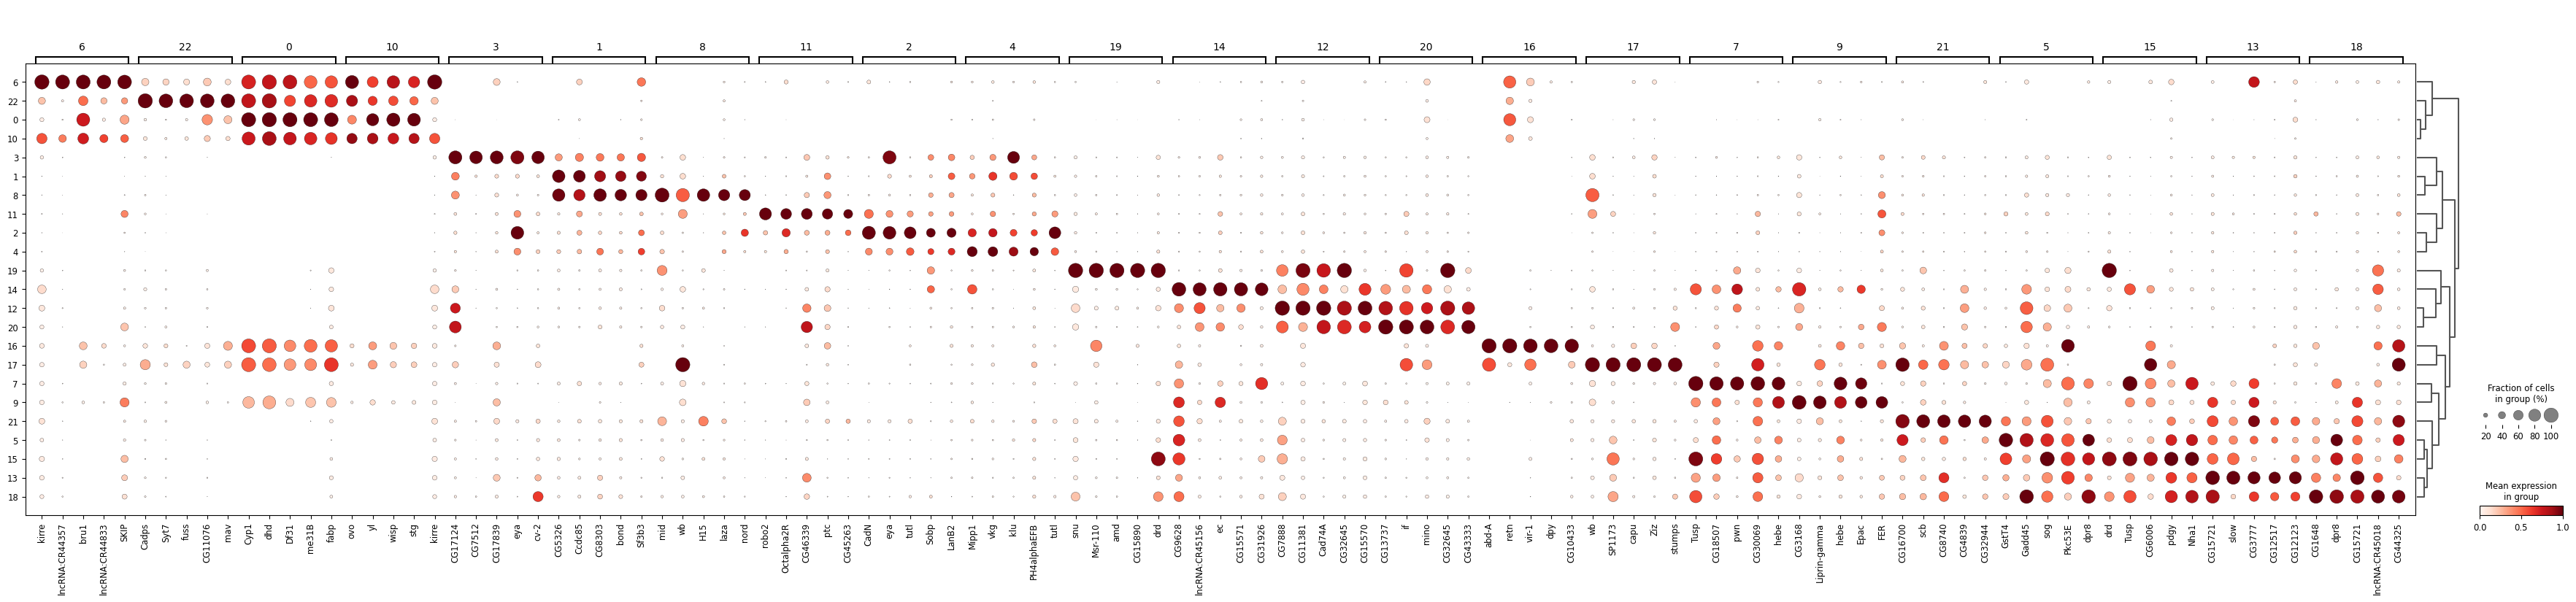

In [46]:
# filter the differentially expressed genes to select for more cluster-specific differentially expressed genes:
sc.tl.filter_rank_genes_groups(adata, key="dea_leiden_1", min_in_group_fraction=0.2, max_out_group_fraction=0.2, key_added="dea_leiden_1_filtered")

#Visualise: 
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res1", standard_scale="var", n_genes=5, key="dea_leiden_1_filtered")

In [47]:
markers = pd.DataFrame(adata.uns["dea_leiden_1_filtered"]["names"])

In [54]:
result = adata.uns["dea_leiden_1_filtered"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,18_n,18_p,19_n,19_p,20_n,20_p,21_n,21_p,22_n,22_p
0,Cyp1,0.0,NaN,0.0,NaN,0.0,NaN,0.000000e+00,NaN,0.000000e+00,...,NaN,1.413047e-154,NaN,5.043824e-141,NaN,2.323714e-108,NaN,2.361384e-43,NaN,5.053083e-35
1,dhd,0.0,NaN,0.0,NaN,0.0,NaN,0.000000e+00,NaN,1.197858e-268,...,NaN,6.348458e-113,NaN,2.104026e-140,NaN,1.503856e-152,NaN,2.578746e-40,NaN,1.260438e-33
2,Df31,0.0,NaN,0.0,NaN,0.0,NaN,1.044455e-320,NaN,4.481073e-202,...,NaN,7.588662e-159,NaN,7.873347e-134,NaN,2.373586e-86,NaN,2.440385e-42,NaN,1.113083e-32
3,me31B,0.0,NaN,0.0,NaN,0.0,NaN,0.000000e+00,NaN,4.973946e-184,...,NaN,2.064763e-137,snu,1.109973e-119,NaN,2.568607e-79,NaN,1.686717e-38,NaN,9.916238e-32
4,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.000000e+00,NaN,2.389960e-162,...,NaN,1.072235e-92,NaN,7.251576e-129,CG13737,9.129883e-72,NaN,2.283312e-37,NaN,9.672739e-32


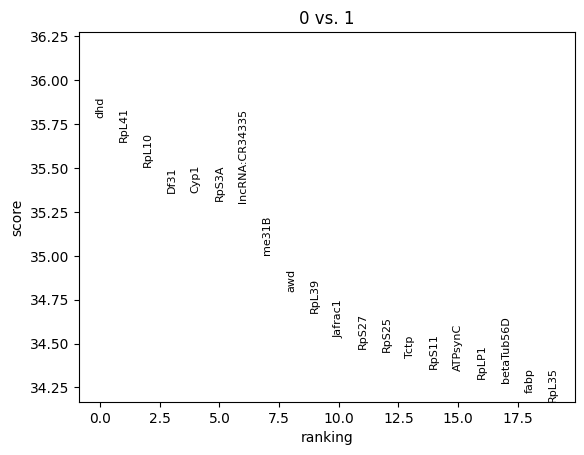

In [56]:
sc.tl.rank_genes_groups(adata, "leiden_res1", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

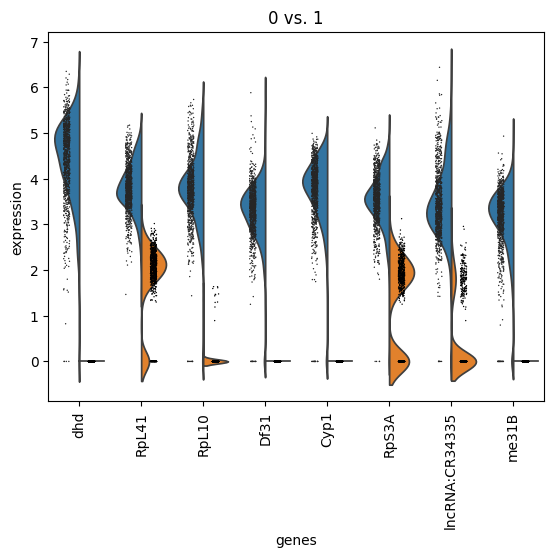

In [57]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

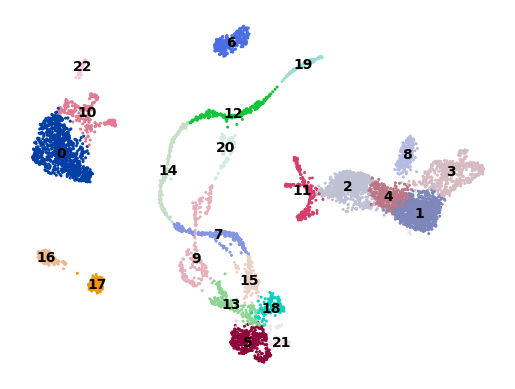

In [60]:
sc.pl.umap(
    adata, color="leiden_res1", legend_loc="on data", title="", frameon=False, save=".pdf"
)

In [62]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [63]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden_res1");

KeyError: "Could not find keys '['CD14', 'CD79A', 'CD8A', 'CD8B', 'CST3', 'FCER1A', 'FCGR3A', 'GNLY', 'IL7R', 'KLRB1', 'LGALS3', 'LYZ', 'MS4A1', 'MS4A7', 'NKG7', 'PPBP', 'S100A8']' in columns of `adata.obs` or in adata.var_names."